In [1]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt

/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [3]:
data = h5py.File("../hdf5_experiments/data/WASP-121b-Fe-6.h5", "r")
data_dir = "./data/WASP-121b-Fe-6-retrieval/"
for key in data.keys():
    flux = data[key]["flux"][:]
    wl_grid = data[key]["wl_grid"][:]
    phi = data[key]["phi"][:]
    tranist_weight = data[key]["transit_weight"][:]
    flux = remove_outliers(wl_grid, flux)
    add_high_res_data(
        data_dir,
        key,
        flux,
        wl_grid,
        phi,
        tranist_weight,
        overwrite=True,
    )

8722 outliers removed from a total of 9302280 pixels
Creating raw data at ./data/WASP-121b-Fe-6-retrieval/blue/data_raw.hdf5
19684 outliers removed from a total of 11863020 pixels
Creating raw data at ./data/WASP-121b-Fe-6-retrieval/redl/data_raw.hdf5
34002 outliers removed from a total of 8210448 pixels
Creating raw data at ./data/WASP-121b-Fe-6-retrieval/redu/data_raw.hdf5


In [4]:
for key in data.keys():
    prepare_high_res_data(
        data_dir,
        key,
        "transmission",
        "sysrem_2022",
        overwrite=True,
        Print=True,
        niter=15,
        n_PC=5,
    )

Creating processed data at ./data/WASP-121b-Fe-6-retrieval/blue/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Fitting out median spectrum from each exposure
Filtering out systematics using SYSREM with 15 iterations
Creating processed data at ./data/WASP-121b-Fe-6-retrieval/redl/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Fitting out median spectrum from each exposure
Filtering out systematics using SYSREM with 15 iterations
Creating processed data at ./data/WASP-121b-Fe-6-retrieval/redu/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Fitting out median spectrum from each exposure
Filtering out systematics using SYSREM with 15 iterations


In [103]:
# The code below will only be run on one core to get the model spectrum.
# if __name__ == "__main__":
R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effectsive temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.753 * R_J  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# ***** Define model *****#

model_name = "Fe -6"  # Model name used for plots, output files etc.
bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# for species in ["Fe", "Li", "Mg", "Ti"]:
species = "Fe"
param_species = [species]

model = define_model(model_name, bulk_species, param_species, PT_profile="isotherm")
# cloud_model="MacMad17", cloud_type="deck")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um) 0.37
wl_max = 0.87  # Maximum wavelength (um) 1.05
R = 250000  # Spectral resolution of grid
model["R"] = R
model["R_instrument"] = 66000  # Resolution of instrument

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Free parameters: ['R_p_ref' 'T' 'log_Fe']


Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done


: 

In [ ]:
# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 2e-2  # Reference pressure (bar)
R_p_ref = 1.8 * R_J  # Radius at reference pressure

params = (-6, 3000)
log_species, T = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_species]])
cloud_params = np.array([[np.log10(0.05)]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

In [ ]:
data_dir = "./data/WASP-121b-Fe-6/"
data = read_high_res_data(data_dir, names=["redu", "redl", "blue"])

In [ ]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-100, 101, 1)
RV_range = np.arange(-400, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        spectrum - gaussian_filter1d(maximum_filter1d(spectrum, 2800), 800),
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlating phase 0
Cross correlating phase 1
Cross correlating phase 2
Cross correlating phase 3
Cross correlating phase 4
Cross correlating phase 5
Cross correlating phase 6
Cross correlating phase 7
Cross correlating phase 8
Cross correlating phase 9
Cross correlating phase 10
Cross correlating phase 11
Cross correlating phase 12
Cross correlating phase 13
Cross correlating phase 14
Cross correlating phase 15
Cross correlating phase 16
Cross correlating phase 17
Cross correlating phase 18
Cross correlating phase 19
Cross correlating phase 20
Cross correlating phase 21
Cross correlating phase 22
Cross correlating phase 23
Cross correlating phase 24
Cross correlating phase 25
Cross correlating phase 26
Cross correlating phase 27
Cross correlating phase 28
Cross correlating phase 29
Cross correlating phase 30
Cross correlating phase 31
Cross correlating phase 32
Cross correlating phase 33
Cross correlating phase 34
Cross correlating phase 35
Cross correlating phase 36
Cross corre

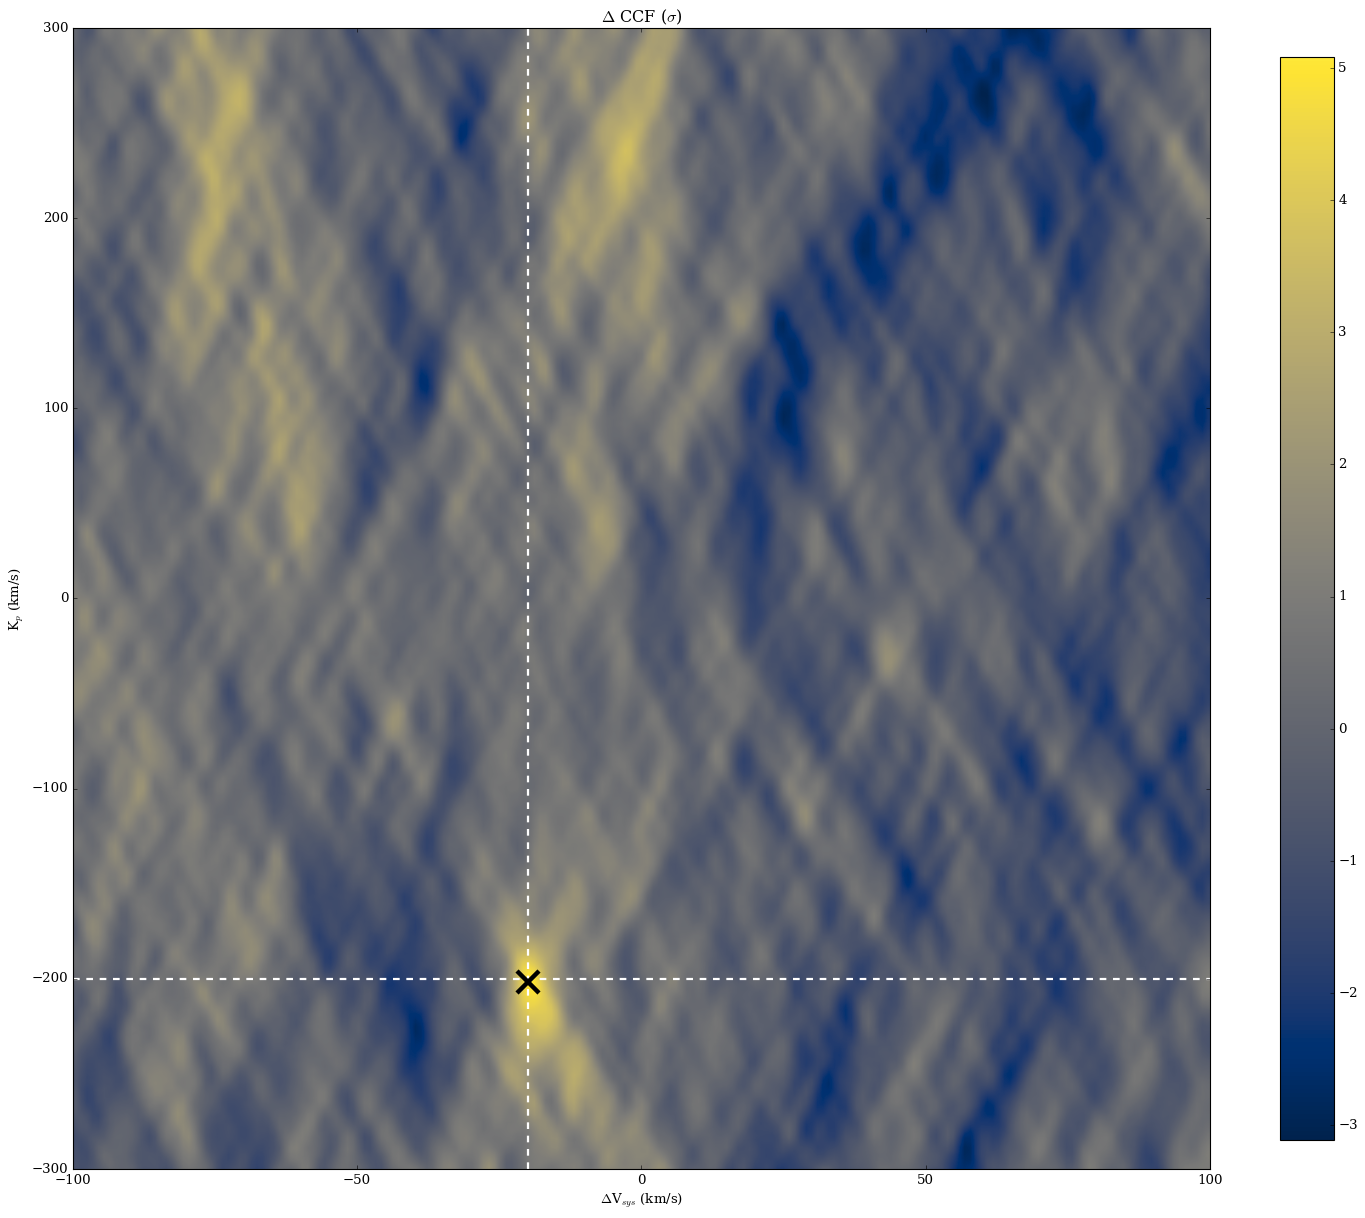

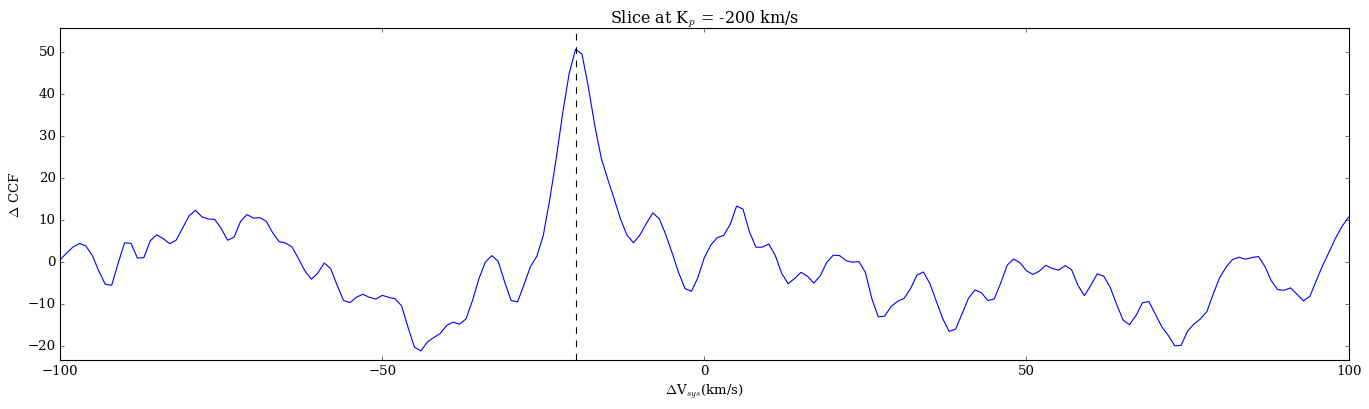

In [ ]:
plot_CCF_Kp_Vsys(
    Kp_range, Vsys_range, np.sum(CCF_Kp_Vsys_all[1:2], axis=0), "Fe", -200, Vsys=-20
)